# Setup

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import operator
from collections import defaultdict
from matplotlib import pyplot as plt

In [2]:
TRAIN_PATH = os.environ['TRAINING_DATA_LOCATION']
TEST_PATH = os.environ['TEST_DATA_LOCATION']

# Load data

In [100]:
train_df = pd.read_csv(os.path.join(TRAIN_PATH, 'train.csv'), parse_dates=['date'],index_col='id')
train_df

/opt/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,2013-01-01,1,BABY CARE,0.000,0
2,2013-01-01,1,BEAUTY,0.000,0
3,2013-01-01,1,BEVERAGES,0.000,0
4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0
3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,2017-08-15,9,PRODUCE,2419.729,148


In [29]:
test_df = pd.read_csv(os.path.join(TEST_PATH, 'test.csv'), parse_dates=['date'], index_col='id')
test_df

,date,store_nbr,family,onpromotion
id,,,,
3000888,2017-08-16,1,AUTOMOTIVE,0
3000889,2017-08-16,1,BABY CARE,0
3000890,2017-08-16,1,BEAUTY,2
3000891,2017-08-16,1,BEVERAGES,20
3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...
3029395,2017-08-31,9,POULTRY,1
3029396,2017-08-31,9,PREPARED FOODS,0
3029397,2017-08-31,9,PRODUCE,1


In [81]:
all_dates = pd.concat([
    pd.Series(train_df['date'].unique()),
    pd.Series(test_df['date'].unique())
]).sort_values()
assert all_dates.nunique() == len(all_dates)
all_dates_index = pd.DatetimeIndex(all_dates)
all_dates_index


DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25',
               '2017-08-26', '2017-08-27', '2017-08-28', '2017-08-29',
               '2017-08-30', '2017-08-31'],
              dtype='datetime64[ns]', length=1700, freq=None)

In [28]:
holidays_df = pd.read_csv(os.path.join(TRAIN_PATH, 'holidays_events.csv'), parse_dates=['date'], index_col='date')
holidays_df

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...
2017-12-22,Additional,National,Ecuador,Navidad-3,False
2017-12-23,Additional,National,Ecuador,Navidad-2,False
2017-12-24,Additional,National,Ecuador,Navidad-1,False


In [84]:
oil_df = pd.read_csv(os.path.join(TRAIN_PATH, 'oil.csv'), parse_dates=['date'], index_col='date')
oil_df.sort_index(inplace=True)
oil_df

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20
...,...
2017-08-25,47.65
2017-08-28,46.40
2017-08-29,46.46


In [25]:
stores_df = pd.read_csv(os.path.join(TRAIN_PATH, 'stores.csv'), index_col='store_nbr')
stores_df

,city,state,type,cluster
store_nbr,,,,
1,Quito,Pichincha,D,13
2,Quito,Pichincha,D,13
3,Quito,Pichincha,D,8
4,Quito,Pichincha,D,9
5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
6,Quito,Pichincha,D,13
7,Quito,Pichincha,D,8
8,Quito,Pichincha,D,8
9,Quito,Pichincha,B,6


In [32]:
transactions_df = pd.read_csv(os.path.join(TRAIN_PATH, 'transactions.csv'), parse_dates=['date'], index_col=['date', 'store_nbr'])
transactions_df

transactions
date       store_nbr              
2013-01-01 25                  770
2013-01-02 1                  2111
           2                  2358
           3                  3487
           4                  1922
...                            ...
2017-08-15 50                 2804
           51                 1573
           52                 2255
           53                  932
           54                  802

[83488 rows x 1 columns]

## Impute oil prices with the mean of neighbouring days

The first problem to solve is that the oil prices do no cover all the days in the train/test data.

In [95]:
filled_oil_df = pd.DataFrame(index=all_dates_index)
filled_oil_df = filled_oil_df.join(oil_df, how='left')
filled_oil_df

,dcoilwtico
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-05,NaN
...,...
2017-08-27,NaN
2017-08-28,46.40
2017-08-29,46.46
2017-08-30,45.96


In [96]:
filled_oil_df['oil_price'] = filled_oil_df['dcoilwtico'].interpolate().fillna(method='bfill')
filled_oil_df[filled_oil_df.index.isin([
    pd.Timestamp('2017-06-30'),
    pd.Timestamp('2017-07-01'),
    pd.Timestamp('2017-07-02'),
    pd.Timestamp('2017-07-03'),
    pd.Timestamp('2017-07-04'),
    pd.Timestamp('2017-07-05'),
    pd.Timestamp('2017-07-06')
])]

,dcoilwtico,oil_price
2017-06-30,46.02,46.020
2017-07-01,NaN,45.838
2017-07-02,NaN,45.656
2017-07-03,NaN,45.474
2017-07-04,NaN,45.292
2017-07-05,45.11,45.110
2017-07-06,45.52,45.520


In [97]:
filled_oil_df.drop('dcoilwtico', axis=1, inplace=True)
filled_oil_df

,oil_price
2013-01-01,93.140000
2013-01-02,93.140000
2013-01-03,92.970000
2013-01-04,93.120000
2013-01-05,93.146667
...,...
2017-08-27,46.816667
2017-08-28,46.400000
2017-08-29,46.460000
2017-08-30,45.960000


# Join oil prices to the main dataframe

In [101]:
train_df = train_df.join(filled_oil_df, on='date', how='left')
train_df

,date,store_nbr,family,sales,onpromotion,oil_price
id,,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.000,0,93.14
1,2013-01-01,1,BABY CARE,0.000,0,93.14
2,2013-01-01,1,BEAUTY,0.000,0,93.14
3,2013-01-01,1,BEVERAGES,0.000,0,93.14
4,2013-01-01,1,BOOKS,0.000,0,93.14
...,...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0,47.57
3000884,2017-08-15,9,PREPARED FOODS,154.553,1,47.57
3000885,2017-08-15,9,PRODUCE,2419.729,148,47.57


Make sure that there are no missing values

In [102]:
train_df.oil_price.isna().sum() / len(train_df)

0.0

In [103]:
test_df = test_df.join(filled_oil_df, on='date', how='left')
test_df

,date,store_nbr,family,onpromotion,oil_price
id,,,,,
3000888,2017-08-16,1,AUTOMOTIVE,0,46.80
3000889,2017-08-16,1,BABY CARE,0,46.80
3000890,2017-08-16,1,BEAUTY,2,46.80
3000891,2017-08-16,1,BEVERAGES,20,46.80
3000892,2017-08-16,1,BOOKS,0,46.80
...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,1,47.26
3029396,2017-08-31,9,PREPARED FOODS,0,47.26
3029397,2017-08-31,9,PRODUCE,1,47.26


Make sure that there are no missing values

In [104]:
test_df.oil_price.isna().sum() / len(test_df)

0.0

# Join store information with main dataframe

In [105]:
# join store information with train df
train_df = train_df.join(stores_df, on='store_nbr', how='left')
train_df

,date,store_nbr,family,sales,onpromotion,oil_price,city,state,type,cluster
id,,,,,,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.000,0,93.14,Quito,Pichincha,D,13
1,2013-01-01,1,BABY CARE,0.000,0,93.14,Quito,Pichincha,D,13
2,2013-01-01,1,BEAUTY,0.000,0,93.14,Quito,Pichincha,D,13
3,2013-01-01,1,BEVERAGES,0.000,0,93.14,Quito,Pichincha,D,13
4,2013-01-01,1,BOOKS,0.000,0,93.14,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0,47.57,Quito,Pichincha,B,6
3000884,2017-08-15,9,PREPARED FOODS,154.553,1,47.57,Quito,Pichincha,B,6
3000885,2017-08-15,9,PRODUCE,2419.729,148,47.57,Quito,Pichincha,B,6


In [107]:
assert train_df.city.isna().sum() == 0

In [108]:
test_df = test_df.join(stores_df, on='store_nbr', how='left')
test_df

,date,store_nbr,family,onpromotion,oil_price,city,state,type,cluster
id,,,,,,,,,
3000888,2017-08-16,1,AUTOMOTIVE,0,46.80,Quito,Pichincha,D,13
3000889,2017-08-16,1,BABY CARE,0,46.80,Quito,Pichincha,D,13
3000890,2017-08-16,1,BEAUTY,2,46.80,Quito,Pichincha,D,13
3000891,2017-08-16,1,BEVERAGES,20,46.80,Quito,Pichincha,D,13
3000892,2017-08-16,1,BOOKS,0,46.80,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,1,47.26,Quito,Pichincha,B,6
3029396,2017-08-31,9,PREPARED FOODS,0,47.26,Quito,Pichincha,B,6
3029397,2017-08-31,9,PRODUCE,1,47.26,Quito,Pichincha,B,6


In [109]:
assert test_df.city.isna().sum() == 0

# Join transactions with main dataframe

In [111]:
# join transaction information with train df
train_df = train_df.join(transactions_df, on=['date', 'store_nbr'], how='left')
train_df

,date,store_nbr,family,sales,onpromotion,oil_price,city,state,type,cluster,transactions
id,,,,,,,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.000,0,93.14,Quito,Pichincha,D,13,NaN
1,2013-01-01,1,BABY CARE,0.000,0,93.14,Quito,Pichincha,D,13,NaN
2,2013-01-01,1,BEAUTY,0.000,0,93.14,Quito,Pichincha,D,13,NaN
3,2013-01-01,1,BEVERAGES,0.000,0,93.14,Quito,Pichincha,D,13,NaN
4,2013-01-01,1,BOOKS,0.000,0,93.14,Quito,Pichincha,D,13,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0,47.57,Quito,Pichincha,B,6,2155.0
3000884,2017-08-15,9,PREPARED FOODS,154.553,1,47.57,Quito,Pichincha,B,6,2155.0
3000885,2017-08-15,9,PRODUCE,2419.729,148,47.57,Quito,Pichincha,B,6,2155.0


In [112]:
train_df[train_df['transactions'].isna()]

,date,store_nbr,family,sales,onpromotion,oil_price,city,state,type,cluster,transactions
id,,,,,,,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,Quito,Pichincha,D,13,NaN
1,2013-01-01,1,BABY CARE,0.0,0,93.14,Quito,Pichincha,D,13,NaN
2,2013-01-01,1,BEAUTY,0.0,0,93.14,Quito,Pichincha,D,13,NaN
3,2013-01-01,1,BEVERAGES,0.0,0,93.14,Quito,Pichincha,D,13,NaN
4,2013-01-01,1,BOOKS,0.0,0,93.14,Quito,Pichincha,D,13,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2790409,2017-04-19,52,POULTRY,0.0,0,50.49,Manta,Manabi,A,11,NaN
2790410,2017-04-19,52,PREPARED FOODS,0.0,0,50.49,Manta,Manabi,A,11,NaN
2790411,2017-04-19,52,PRODUCE,0.0,0,50.49,Manta,Manabi,A,11,NaN


# Analyze surnames

In [14]:
train_names = train_df['Name'].str.split(' ').str[-1].dropna().unique()
test_names = test_df['Name'].str.split(' ').str[-1].dropna().unique()

## How many surnames from test set also appear in train set

In [15]:
len(set(train_names) & set(test_names)) / len(test_names)

0.8904347826086957

That's most of them.

# Analize cabins

In [16]:
train_cabins = train_df['Cabin'].dropna().unique()
test_cabins = test_df['Cabin'].dropna().unique()

## How many cabins from tests set also appear in train set

In [17]:
len(set(train_cabins) & set(test_cabins)) / len(test_cabins)

0.0

In [18]:
set(train_cabins) & set(test_cabins)

set()

None of the cabins are shared between train and test sets

# Analyze passenger groups

In [19]:
train_pgs = train_df['PassengerId'].str.split('_').str[0].dropna().unique()
test_pgs = test_df['PassengerId'].str.split('_').str[0].dropna().unique()

In [21]:
## How many passenger groups are shared between sets

In [20]:
len(set(train_pgs) & set(test_pgs)) / len(test_pgs)

0.0

None of the passenger groups are shared.

# Analyze cabin survival

Check if there is any discernable pattern to which cabins survived.

In [26]:
train_df['cabin_deck'] = train_df['Cabin'].str.split('/').str[0]
train_df['cabin_num'] = pd.to_numeric(train_df['Cabin'].str.split('/').str[1])
train_df['cabin_side'] = train_df['Cabin'].str.split('/').str[2]

train_df[['cabin_deck', 'cabin_num', 'cabin_side']]

,cabin_deck,cabin_num,cabin_side
0,B,0.0,P
1,F,0.0,S
2,A,0.0,S
3,A,0.0,S
4,F,1.0,S
...,...,...,...
8688,A,98.0,P
8689,G,1499.0,S
8690,G,1500.0,S
8691,E,608.0,S


In [38]:
grouped = train_df.groupby(['cabin_deck', 'cabin_num', 'cabin_side'])
survival = grouped['Transported'].sum() / grouped.size()
survival

cabin_deck  cabin_num  cabin_side
A           0.0        P             0.5
                       S             0.0
            1.0        S             1.0
            2.0        P             1.0
                       S             0.0
                                    ... 
T           0.0        P             0.0
            1.0        P             0.0
            2.0        P             0.0
                       S             0.0
            3.0        P             1.0
Length: 6560, dtype: float64

In [51]:
deck_sizes = train_df.groupby(['cabin_deck']).cabin_num.max()
deck_sizes

cabin_deck
A     107.0
B     353.0
C     342.0
D     295.0
E     608.0
F    1894.0
G    1508.0
T       3.0
Name: cabin_num, dtype: float64

In [53]:
sides = ['P', 'S']

In [54]:
containers = {}
for (deck, ), max_cabin in deck_sizes.items():
    container = np.zeros((2, int(max_cabin) + 1, ), dtype=np.float32)
    container.fill(np.nan)
    containers[deck] = container

In [55]:
for (deck, num, side), rate in survival.items():
    side_idx = sides.index(side)
    containers[deck][side_idx][int(num)] = rate

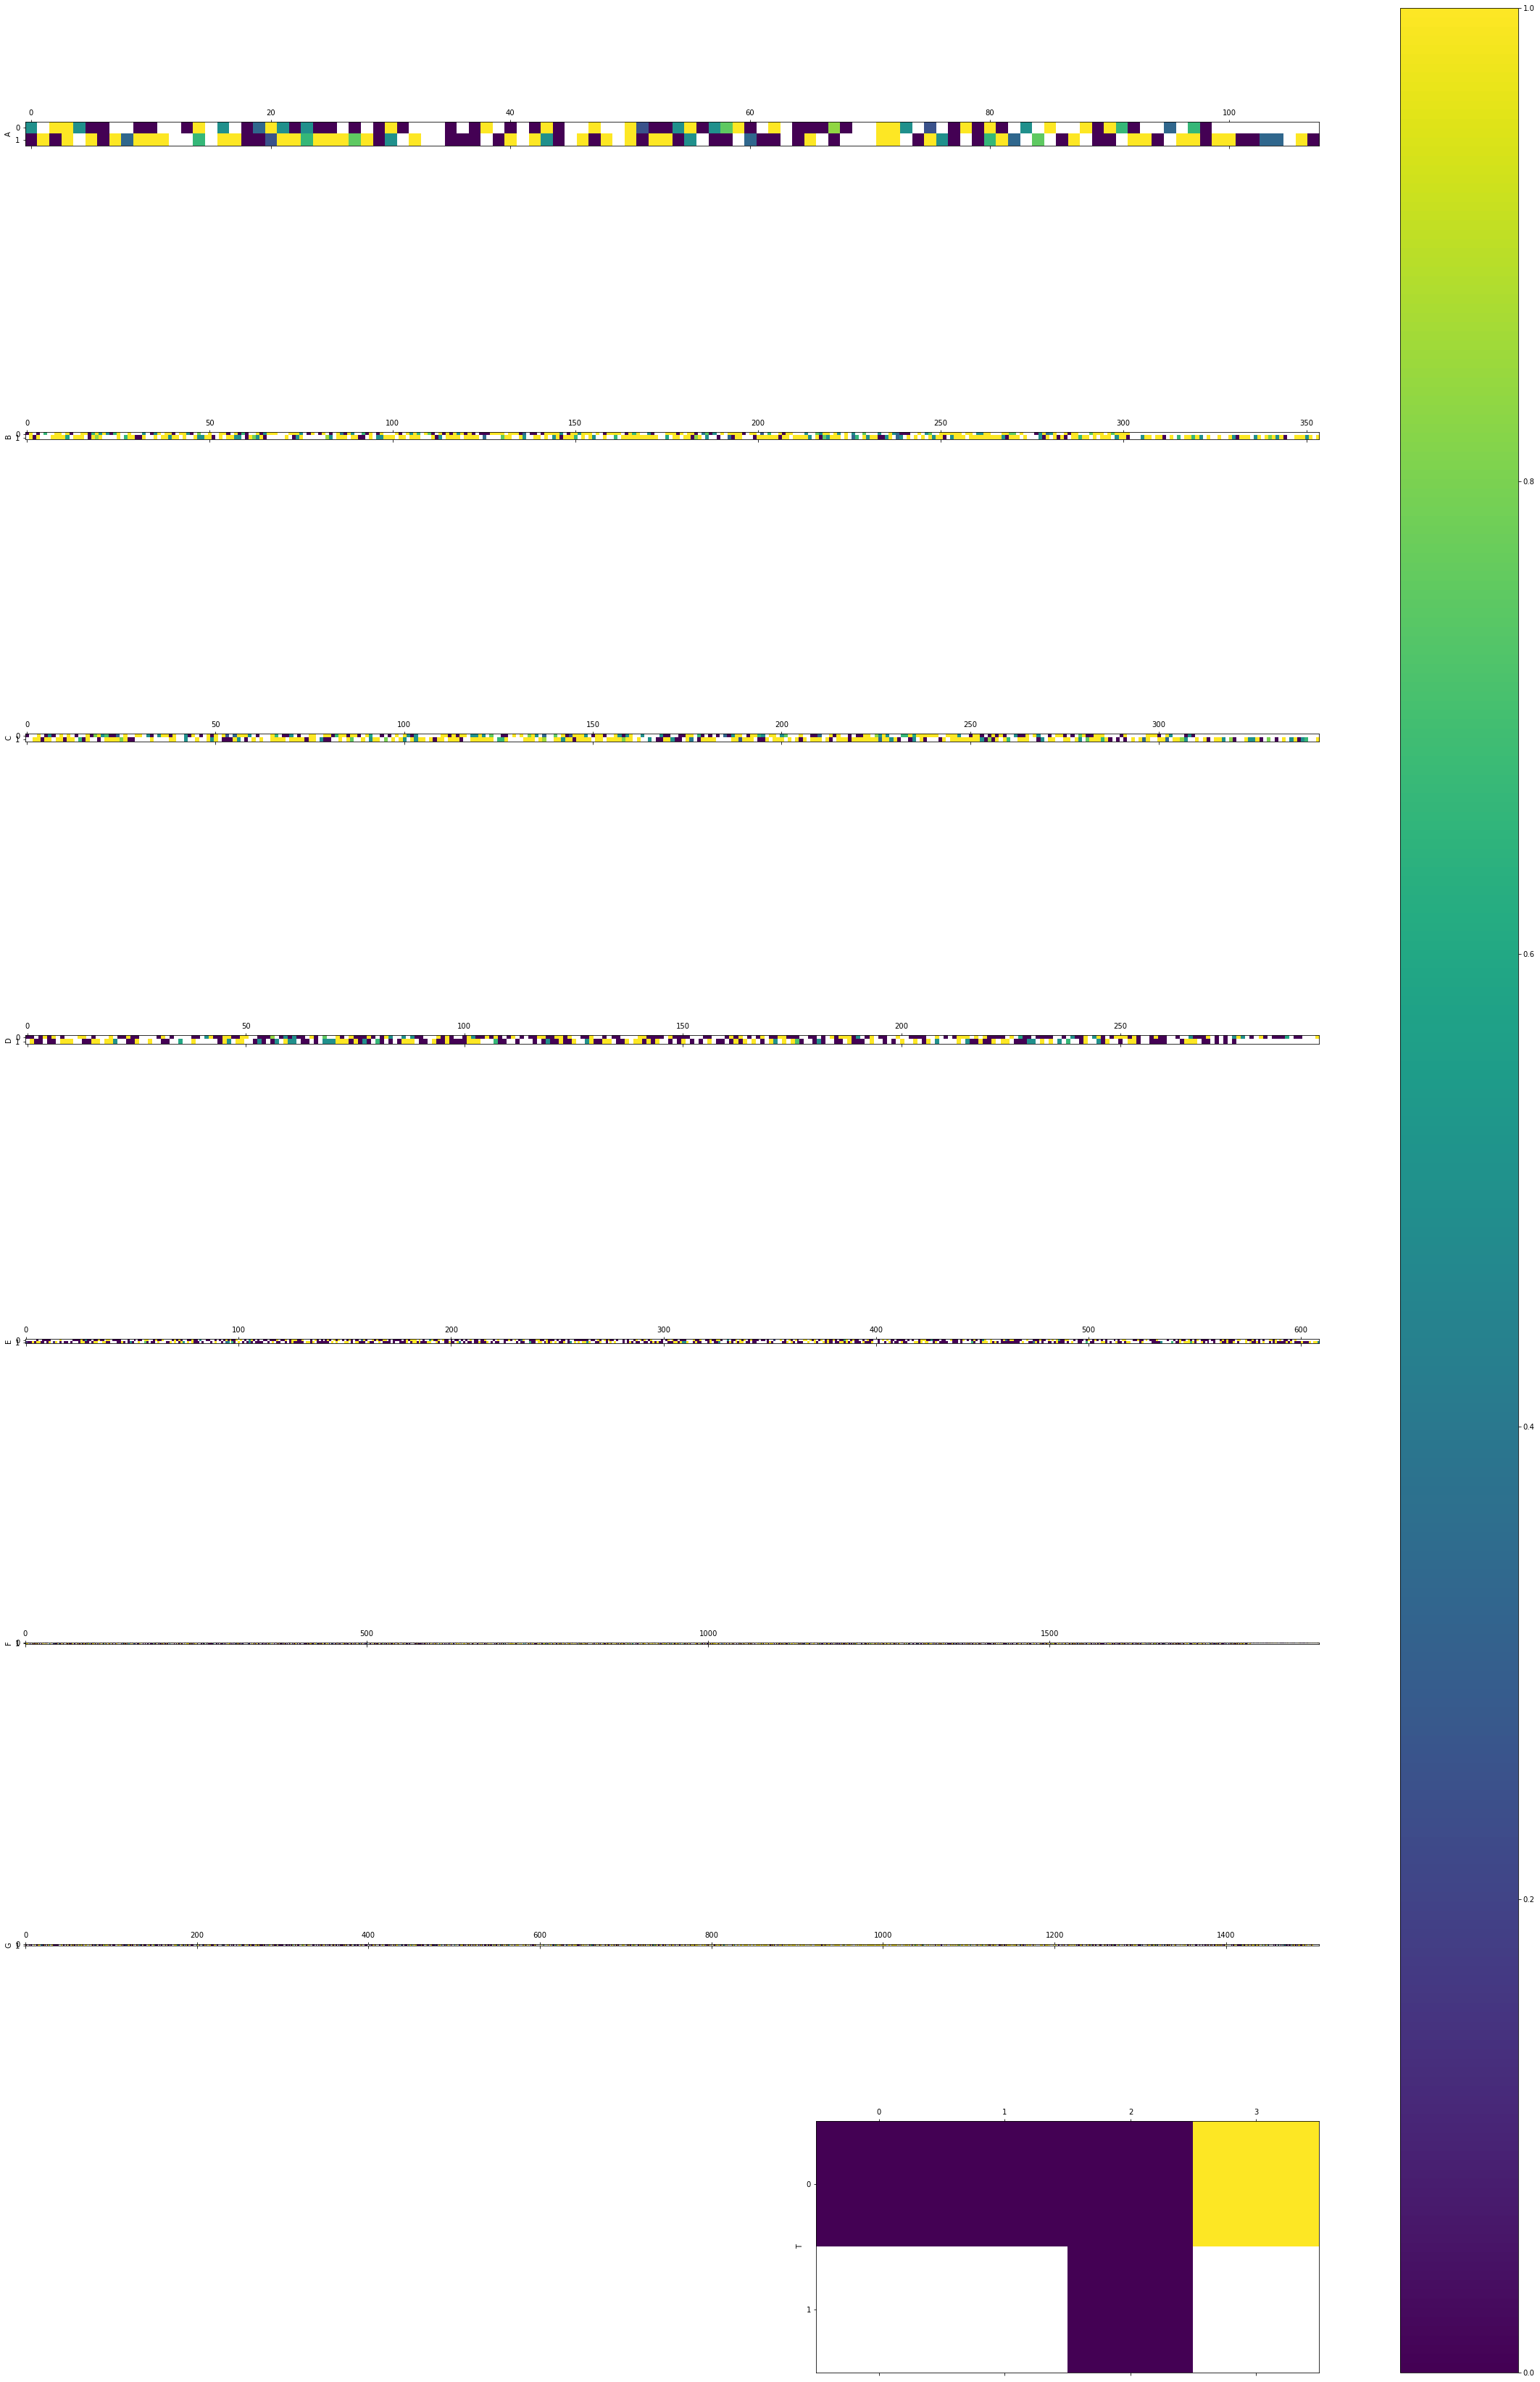

In [69]:
fig, axes = plt.subplots(len(containers), 1, figsize=(40, 60))
for ax, deck in zip(axes, sorted(containers)):
    ax.set_ylabel(deck)
    im = ax.matshow(containers[deck])
_ = fig.colorbar(im, ax=axes.ravel().tolist())

# Analyze surnames

In [77]:
all_names = set(np.concatenate([train_names, test_names]))
sorted_names = sorted(all_names)
len(sorted_names)

2406

In [78]:
sorted_names[:100]

['Acobson',
 'Acobsond',
 'Adavisons',
 'Adkinson',
 'Admingried',
 'Ageurante',
 'Aginge',
 'Aginoid',
 'Ailled',
 'Aillyber',
 'Aiming',
 'Ainatint',
 'Aindlylid',
 'Ainserfle',
 'Airdring',
 'Aivering',
 'Alaring',
 'Alaxed',
 'Alberts',
 'Alcemblery',
 'Alenat',
 'Alenter',
 'Alentonway',
 'Alest',
 'Alfordonard',
 'Alindiveng',
 'Alldson',
 'Aloquinght',
 'Aloubtled',
 'Alshipson',
 'Alutorody',
 'Alvasquez',
 'Alvercal',
 'Alvesssidy',
 'Ambleetive',
 'Ambleeve',
 'Amblereld',
 'Ametic',
 'Amincrerus',
 'Amonsmane',
 'Amonysidle',
 'Amoutake',
 'Amsive',
 'Amspring',
 'Anake',
 'Anate',
 'Anche',
 'Ancontaked',
 'Ancy',
 'Andackson',
 'Anderking',
 'Andley',
 'Ane',
 'Aneetle',
 'Aneter',
 'Anindery',
 'Anpie',
 'Antcal',
 'Anthompson',
 'Anthon',
 'Antoshipson',
 'Apeau',
 'Apedishaft',
 'Apenelexy',
 'Apie',
 'Apity',
 'Appie',
 'Apple',
 'Arible',
 'Armstromez',
 'Arner',
 'Arneras',
 'Aroodint',
 'Arterate',
 'Asharing',
 'Ashipeck',
 'Ashipson',
 'Asivetfuel',
 'Asolipery',


We don't see any pattern like `Kowalska`, `Kowalski` that could be applied to cleanup the names.